In [21]:
!pip install sentence-transformers
!pip install torch==2.0.1+cu118 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tensorflow
!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 489.8 MB 112.3 MB/s eta 0:00:01     |████████████████████████████████| 489.8 MB 18 kB/s 
     |████████████████████████████████| 57 kB 5.8 MB/s s eta 0:00:01
     |████████████████████████████████| 440 kB 141.2 MB/s eta 0:00:01
     |████████████████████████████████| 22.9 MB 152.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 136.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 133.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 34.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 158.7 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 4.4 MB/s s eta 0:00:01


In [37]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import gzip
import torch
import random
import tensorflow as tf
import nltk

from ast import literal_eval
from itertools import zip_longest
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer, util, models
from tensorflow import keras
from torch.cuda import is_available
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel, RobertaTokenizer, RobertaModel
from tqdm import tqdm

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

import numpy as np

SEED = 42

## Extract dataframe

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df_0 = getDF('Sports_and_Outdoors_5.json.gz')

## Clean dataframe

In [4]:
df = df_0[["overall", "reviewText"]]
df = df.rename(columns={"overall": "rating", "reviewText": "review"})
df["review"] = df["review"].astype(str)
df.head()

,rating,review
0,5.0,What a spectacular tutu! Very slimming.
1,1.0,What the heck? Is this a tutu for nuns? I know...
2,5.0,Exactly what we were looking for!
3,5.0,I used this skirt for a Halloween costume and ...
4,4.0,This is thick enough that you can't see throug...


#### Observe that the majority of votes are 5 stars

In [5]:
df.value_counts("rating")

rating
5.0    1921398
4.0     495533
3.0     210215
1.0     111157
2.0     101637
dtype: int64

Text(0.5, 0, 'Rating')

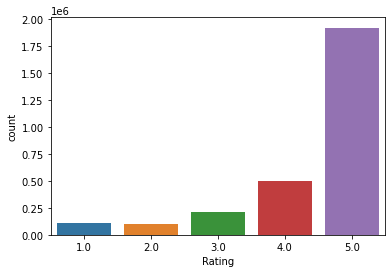

In [7]:
cplot = sns.countplot(data=df_0[["overall", "reviewText"]], x="overall")
cplot.set_xlabel("Rating")

# SBERT

#### Balance dataframe

In [6]:
min_rating_count = df['rating'].value_counts().min()

balanced_dfs = []

for rating in df['rating'].unique():
    rating_df = df[df['rating'] == rating]
    selected_rows = rating_df.sample(n=min_rating_count, random_state=1)
    balanced_dfs.append(selected_rows)

balanced_df = pd.concat(balanced_dfs)
df = balanced_df

#### Add SBERT encodings of reviews

In [8]:
sbert_model = SentenceTransformer(model_name_or_path='paraphrase-MiniLM-L12-v2')

sbert_model.max_seq_length = 512

if torch.cuda.is_available():
    sbert_model.to('cuda')
    print("Using GPU")
    print(f"Model is running on device: {next(sbert_model.parameters()).device}")

encoded_reviews = []

def encode_text_with_progress(text):
    encoding = sbert_model.encode(text)
    return encoding

for text in tqdm(df['review']):
    encoded_reviews.append(encode_text_with_progress(text).flatten())

df['encoded_review'] = encoded_reviews


Using GPU
Model is running on device: cuda:0


100%|██████████| 508185/508185 [1:11:50<00:00, 117.89it/s]


In [45]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

if torch.cuda.is_available():
    bert_model.to('cuda')
    print("Using GPU")
    print(f"Model is running on device: {next(bert_model.parameters()).device}")

encoded_reviews_bert = []

def encode_text_with_progress_bert(text):
    tokens = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    with torch.no_grad():
        outputs = bert_model(**tokens)

    embeddings = outputs.last_hidden_state
    pooled_embedding = torch.mean(embeddings, dim=1)

    return pooled_embedding

for text in tqdm(df['review']):
    encoding = encode_text_with_progress_bert(text).flatten().cpu().numpy()
    encoded_reviews_bert.append(encoding)

max_len = max(len(enc) for enc in encoded_reviews_bert)
padded_encodings = [np.pad(enc, (0, max_len - len(enc))) for enc in encoded_reviews_bert]

df["encoded_review_bert"] = padded_encodings

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using GPU
Model is running on device: cuda:0


100%|██████████| 508185/508185 [1:06:27<00:00, 127.44it/s]


In [30]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

if torch.cuda.is_available():
    roberta_model.to('cuda')
    print("Using GPU")
    print(f"Model is running on device: {next(roberta_model.parameters()).device}")

encoded_reviews_roberta = []

def encode_text_with_progress_roberta(text):
    tokens = roberta_tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)

    if torch.cuda.is_available():
        tokens = {key: val.to('cuda') for key, val in tokens.items()}

    with torch.no_grad():
        output = roberta_model(**tokens)

    encoding = output.last_hidden_state.mean(dim=1).flatten()
    return encoding.cpu().numpy()

for text in tqdm(df['review']):
    encoded_reviews_roberta.append(encode_text_with_progress_roberta(text))

df['encoded_review_roberta'] = encoded_reviews_roberta

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using GPU
Model is running on device: cuda:0


100%|██████████| 508185/508185 [1:02:30<00:00, 135.51it/s]


___
___
___

# 5-way classification

## Create train/test split

In [117]:
X_train_sbert, X_test_sbert, y_train, y_test = train_test_split(np.array(df["encoded_review_sbert"].values.tolist()), df["rating"].values, test_size=0.2, random_state=SEED)

unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([1., 2., 3., 4., 5.]), array([81350, 81283, 81264, 81385, 81266]))

In [119]:
X_train_bert, X_test_bert, y_train, y_test = train_test_split(df["encoded_review_bert"].values.tolist(), df["rating"].values, test_size=0.2, random_state=SEED)

unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([1., 2., 3., 4., 5.]), array([81350, 81283, 81264, 81385, 81266]))

In [124]:
X_train_roberta, X_test_roberta, y_train, y_test = train_test_split(df["encoded_review_roberta"].values.tolist(), df["rating"].values, test_size=0.2, random_state=SEED)

unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([1., 2., 3., 4., 5.]), array([81350, 81283, 81264, 81385, 81266]))

## Decision Tree

In [116]:
# SBERT

decision_tree = DecisionTreeClassifier(random_state=SEED)
decision_tree.fit(X_train_sbert, y_train)
y_pred = decision_tree.predict(X_test_sbert)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets)/len(offsets), 3)}")

Accuracy: 0.381
Average difference between predicted rating and ground truth: 1.009


In [18]:
# BERT

decision_tree = DecisionTreeClassifier(random_state=SEED)
decision_tree.fit(X_train_bert, y_train)
y_pred = decision_tree.predict(X_test_bert)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets)/len(offsets), 3)}")

Accuracy: 0.386
Average difference between predicted rating and ground truth: 1.016


In [32]:
# ROBERTA

decision_tree = DecisionTreeClassifier(random_state=SEED)
decision_tree.fit(X_train_roberta, y_train)
y_pred = decision_tree.predict(X_test_roberta)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets)/len(offsets), 3)}")

Accuracy: 0.395
Average difference between predicted rating and ground truth: 0.982


#### Cross validate decision tree

In [118]:
# SBERT

decision_tree = DecisionTreeClassifier(random_state=SEED)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_sbert, y_train)

best_decision_tree = grid_search.best_estimator_

y_pred = best_decision_tree.predict(X_test_sbert)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"Test Accuracy with Best Model: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets)/len(offsets), 3)}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test Accuracy with Best Model: 0.381
Average difference between predicted rating and ground truth: 0.925


In [121]:
# BERT

decision_tree = DecisionTreeClassifier(random_state=SEED)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_bert, y_train)

best_decision_tree = grid_search.best_estimator_

y_pred = best_decision_tree.predict(X_test_bert)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"Test Accuracy with Best Model: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets)/len(offsets), 3)}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test Accuracy with Best Model: 0.385
Average difference between predicted rating and ground truth: 0.962


In [125]:
# RoBERTa

decision_tree = DecisionTreeClassifier(random_state=SEED)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_roberta, y_train)

best_decision_tree = grid_search.best_estimator_

y_pred = best_decision_tree.predict(X_test_roberta)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"Test Accuracy with Best Model: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets)/len(offsets), 3)}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy with Best Model: 0.398
Average difference between predicted rating and ground truth: 0.918


## SVC (c for discrete classification, m for continous)

In [11]:
# SBERT

linear_svc_classifier = LinearSVC(random_state=SEED)
linear_svc_classifier.fit(X_train_sbert, y_train)
y_pred = linear_svc_classifier.predict(X_test_sbert)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

Accuracy: 0.496
Average difference between predicted rating and ground truth: 0.708


/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [19]:
#BERT

linear_svc_classifier = LinearSVC(random_state=SEED)
linear_svc_classifier.fit(X_train_bert, y_train)
y_pred = linear_svc_classifier.predict(X_test_bert)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.516
Average difference between predicted rating and ground truth: 0.655


In [43]:
#ROBERTA

linear_svc_classifier = LinearSVC(random_state=SEED)
linear_svc_classifier.fit(X_train_roberta, y_train)
y_pred = linear_svc_classifier.predict(X_test_roberta)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")

offsets = [abs(t - p) for t, p in zip(y_test, y_pred)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.541
Average difference between predicted rating and ground truth: 0.595


## Neural Network

In [13]:
X_train = np.array(X_train_sbert)
X_test = np.array(X_test_sbert)
y_train_ohe = keras.utils.to_categorical(y_train - 1, num_classes=5)
y_test_ohe = keras.utils.to_categorical(y_test - 1, num_classes=5)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train, y_train_ohe, epochs=10, batch_size=32, validation_data=(X_test, y_test_ohe))

loss, accuracy = model.evaluate(X_test, y_test_ohe)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

predictions = model.predict(X_test)

offsets = [abs(t - p) for t, p in zip(y_test, np.argmax(predictions, axis=1) + 1)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

2023-11-13 11:28:03.940266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77855 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:48:00.0, compute capability: 8.0


Epoch 1/10


2023-11-13 11:28:03.987034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78407 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:8a:00.0, compute capability: 8.0
2023-11-13 11:28:03.988129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78407 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0
2023-11-13 11:28:03.989111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78407 MB memory:  -> device: 3, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c1:00.0, compute capability: 8.0
2023-11-13 11:28:11.722179: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 11:28:12.484572: I tensorflow/compiler/xla/service/service.cc:168

12705/12705 [==============================] - 31s 2ms/step - loss: 1.1341 - accuracy: 0.4985 - val_loss: 1.1105 - val_accuracy: 0.5096
Epoch 2/10
12705/12705 [==============================] - 24s 2ms/step - loss: 1.0979 - accuracy: 0.5158 - val_loss: 1.1013 - val_accuracy: 0.5127
Epoch 3/10
12705/12705 [==============================] - 24s 2ms/step - loss: 1.0827 - accuracy: 0.5224 - val_loss: 1.0962 - val_accuracy: 0.5164
Epoch 4/10
12705/12705 [==============================] - 24s 2ms/step - loss: 1.0722 - accuracy: 0.5280 - val_loss: 1.0994 - val_accuracy: 0.5153
Epoch 5/10
12705/12705 [==============================] - 24s 2ms/step - loss: 1.0636 - accuracy: 0.5320 - val_loss: 1.0981 - val_accuracy: 0.5170
Epoch 6/10
12705/12705 [==============================] - 24s 2ms/step - loss: 1.0569 - accuracy: 0.5360 - val_loss: 1.0972 - val_accuracy: 0.5151
Epoch 7/10
12705/12705 [==============================] - 24s 2ms/step - loss: 1.0518 - accuracy: 0.5383 - val_loss: 1.0991 - val

In [14]:
# Deep NN

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train, y_train_ohe, epochs=10, batch_size=32, validation_data=(X_test, y_test_ohe))

loss, accuracy = model.evaluate(X_test, y_test_ohe)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

predictions = model.predict(X_test)

offsets = [abs(t - p) for t, p in zip(y_test, np.argmax(predictions, axis=1) + 1)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

Epoch 1/10
12705/12705 [==============================] - 30s 2ms/step - loss: 1.1328 - accuracy: 0.4969 - val_loss: 1.1068 - val_accuracy: 0.5102
Epoch 2/10
12705/12705 [==============================] - 28s 2ms/step - loss: 1.0920 - accuracy: 0.5168 - val_loss: 1.0961 - val_accuracy: 0.5160
Epoch 3/10
12705/12705 [==============================] - 28s 2ms/step - loss: 1.0719 - accuracy: 0.5261 - val_loss: 1.0890 - val_accuracy: 0.5186
Epoch 4/10
12705/12705 [==============================] - 28s 2ms/step - loss: 1.0547 - accuracy: 0.5341 - val_loss: 1.0915 - val_accuracy: 0.5194
Epoch 5/10
12705/12705 [==============================] - 28s 2ms/step - loss: 1.0410 - accuracy: 0.5400 - val_loss: 1.0939 - val_accuracy: 0.5190
Epoch 6/10
12705/12705 [==============================] - 28s 2ms/step - loss: 1.0281 - accuracy: 0.5464 - val_loss: 1.0978 - val_accuracy: 0.5204
Epoch 7/10
12705/12705 [==============================] - 28s 2ms/step - loss: 1.0159 - accuracy: 0.5517 - val_loss: 1

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train, y_train_ohe, epochs=10, batch_size=32, validation_data=(X_test, y_test_ohe))

loss, accuracy = model.evaluate(X_test, y_test_ohe)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

predictions = model.predict(X_test)

offsets = [abs(t - p) for t, p in zip(y_test, np.argmax(predictions, axis=1) + 1)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

Epoch 1/10
12705/12705 [==============================] - 33s 2ms/step - loss: 1.2180 - accuracy: 0.4621 - val_loss: 1.1392 - val_accuracy: 0.4976
Epoch 2/10
12705/12705 [==============================] - 30s 2ms/step - loss: 1.1806 - accuracy: 0.4791 - val_loss: 1.1357 - val_accuracy: 0.4970
Epoch 3/10
12705/12705 [==============================] - 30s 2ms/step - loss: 1.1737 - accuracy: 0.4824 - val_loss: 1.1317 - val_accuracy: 0.5013
Epoch 4/10
12705/12705 [==============================] - 30s 2ms/step - loss: 1.1669 - accuracy: 0.4855 - val_loss: 1.1271 - val_accuracy: 0.4991
Epoch 5/10
12705/12705 [==============================] - 30s 2ms/step - loss: 1.1629 - accuracy: 0.4883 - val_loss: 1.1210 - val_accuracy: 0.5027
Epoch 6/10
12705/12705 [==============================] - 30s 2ms/step - loss: 1.1611 - accuracy: 0.4882 - val_loss: 1.1241 - val_accuracy: 0.5072
Epoch 7/10
12705/12705 [==============================] - 30s 2ms/step - loss: 1.1570 - accuracy: 0.4902 - val_loss: 1

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=1000, output_dim=64))
rnn_model.add(LSTM(128))
rnn_model.add(Dense(5, activation="softmax"))

rnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

rnn_model.fit(X_train, y_train_ohe, epochs=10, batch_size=32, validation_data=(X_test, y_test_ohe))

loss, accuracy = rnn_model.evaluate(X_test, y_test_ohe)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

predictions = rnn_model.predict(X_test)

offsets = [abs(t - p) for t, p in zip(y_test, np.argmax(predictions, axis=1) + 1)]
print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")


Epoch 1/10
12705/12705 [==============================] - 180s 14ms/step - loss: 1.6097 - accuracy: 0.1992 - val_loss: 1.6095 - val_accuracy: 0.1993
Epoch 2/10
12705/12705 [==============================] - 175s 14ms/step - loss: 1.6096 - accuracy: 0.2000 - val_loss: 1.6095 - val_accuracy: 0.1996
Epoch 3/10
12705/12705 [==============================] - 173s 14ms/step - loss: 1.6095 - accuracy: 0.2003 - val_loss: 1.6096 - val_accuracy: 0.2004
Epoch 4/10
12705/12705 [==============================] - 175s 14ms/step - loss: 1.6095 - accuracy: 0.2008 - val_loss: 1.6096 - val_accuracy: 0.2004
Epoch 5/10
12705/12705 [==============================] - 175s 14ms/step - loss: 1.6095 - accuracy: 0.1976 - val_loss: 1.6094 - val_accuracy: 0.1996
Epoch 6/10
12705/12705 [==============================] - 175s 14ms/step - loss: 1.6095 - accuracy: 0.2000 - val_loss: 1.6097 - val_accuracy: 0.1996
Epoch 7/10
12705/12705 [==============================] - 176s 14ms/step - loss: 1.6095 - accuracy: 0.1990

## BERT NN

In [22]:
X_train_bert = np.array(X_train_bert)
X_test_bert = np.array(X_test_bert)
y_train_ohe = keras.utils.to_categorical(y_train - 1, num_classes=5)
y_test_ohe = keras.utils.to_categorical(y_test - 1, num_classes=5)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train_bert.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train_bert, y_train_ohe, epochs=10, batch_size=32, validation_data=(X_test_bert, y_test_ohe))

loss, accuracy = model.evaluate(X_test_bert, y_test_ohe)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

predictions = model.predict(X_test_bert)

offsets = [abs(t - p) for t, p in zip(y_test, np.argmax(predictions, axis=1) + 1)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

2023-11-10 12:55:01.560496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77543 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:48:00.0, compute capability: 8.0
2023-11-10 12:55:01.606642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78407 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:8a:00.0, compute capability: 8.0
2023-11-10 12:55:01.607849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78407 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0
2023-11-10 12:55:01.608891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78407 MB memory:  -> device: 3, name: NVIDIA A100 80GB PCIe, pci bu

Epoch 1/10


2023-11-10 12:55:11.279643: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-10 12:55:12.089136: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bbdd388e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 12:55:12.089209: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-10 12:55:12.089215: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-10 12:55:12.089218: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-10 12:55:12.089222: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-10 12:55:12.415133: I tensorflow/compiler/mlir

12705/12705 [==============================] - 32s 2ms/step - loss: 1.1202 - accuracy: 0.5047 - val_loss: 1.0989 - val_accuracy: 0.5135
Epoch 2/10
12705/12705 [==============================] - 25s 2ms/step - loss: 1.0851 - accuracy: 0.5195 - val_loss: 1.0813 - val_accuracy: 0.5220
Epoch 3/10
12705/12705 [==============================] - 25s 2ms/step - loss: 1.0727 - accuracy: 0.5258 - val_loss: 1.0822 - val_accuracy: 0.5206
Epoch 4/10
12705/12705 [==============================] - 25s 2ms/step - loss: 1.0643 - accuracy: 0.5305 - val_loss: 1.0676 - val_accuracy: 0.5291
Epoch 5/10
12705/12705 [==============================] - 25s 2ms/step - loss: 1.0579 - accuracy: 0.5329 - val_loss: 1.0682 - val_accuracy: 0.5277
Epoch 6/10
12705/12705 [==============================] - 25s 2ms/step - loss: 1.0529 - accuracy: 0.5352 - val_loss: 1.0648 - val_accuracy: 0.5283
Epoch 7/10
12705/12705 [==============================] - 25s 2ms/step - loss: 1.0485 - accuracy: 0.5366 - val_loss: 1.0765 - val

In [23]:
X_train_bert = np.array(X_train_bert)
X_test_bert = np.array(X_test_bert)
y_train_ohe = keras.utils.to_categorical(y_train - 1, num_classes=5)
y_test_ohe = keras.utils.to_categorical(y_test - 1, num_classes=5)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train_bert.shape[1],)),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train_bert, y_train_ohe, epochs=10, batch_size=32, validation_data=(X_test_bert, y_test_ohe))

loss, accuracy = model.evaluate(X_test_bert, y_test_ohe)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

predictions = model.predict(X_test_bert)

offsets = [abs(t - p) for t, p in zip(y_test, np.argmax(predictions, axis=1) + 1)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

Epoch 1/10
12705/12705 [==============================] - 31s 2ms/step - loss: 1.1223 - accuracy: 0.5028 - val_loss: 1.1004 - val_accuracy: 0.5155
Epoch 2/10
12705/12705 [==============================] - 29s 2ms/step - loss: 1.0844 - accuracy: 0.5201 - val_loss: 1.0914 - val_accuracy: 0.5163
Epoch 3/10
12705/12705 [==============================] - 29s 2ms/step - loss: 1.0704 - accuracy: 0.5271 - val_loss: 1.0681 - val_accuracy: 0.5304
Epoch 4/10
12705/12705 [==============================] - 29s 2ms/step - loss: 1.0595 - accuracy: 0.5321 - val_loss: 1.0724 - val_accuracy: 0.5274
Epoch 5/10
12705/12705 [==============================] - 29s 2ms/step - loss: 1.0514 - accuracy: 0.5355 - val_loss: 1.0640 - val_accuracy: 0.5316
Epoch 6/10
12705/12705 [==============================] - 29s 2ms/step - loss: 1.0442 - accuracy: 0.5379 - val_loss: 1.0653 - val_accuracy: 0.5302
Epoch 7/10
12705/12705 [==============================] - 29s 2ms/step - loss: 1.0381 - accuracy: 0.5407 - val_loss: 1

## ROBERTA NN

In [39]:
X_train = np.array(X_train_roberta)
X_test = np.array(X_test_roberta)
y_train_ohe = keras.utils.to_categorical(y_train - 1, num_classes=5)
y_test_ohe = keras.utils.to_categorical(y_test - 1, num_classes=5)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train, y_train_ohe, epochs=10, batch_size=32, validation_data=(X_test, y_test_ohe))

loss, accuracy = model.evaluate(X_test, y_test_ohe)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

predictions = model.predict(X_test)

offsets = [abs(t - p) for t, p in zip(y_test, np.argmax(predictions, axis=1) + 1)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

Epoch 1/10
12705/12705 [==============================] - 33s 2ms/step - loss: 1.0558 - accuracy: 0.5328 - val_loss: 1.0302 - val_accuracy: 0.5438
Epoch 2/10
12705/12705 [==============================] - 24s 2ms/step - loss: 1.0171 - accuracy: 0.5506 - val_loss: 1.0416 - val_accuracy: 0.5405
Epoch 3/10
12705/12705 [==============================] - 24s 2ms/step - loss: 1.0039 - accuracy: 0.5560 - val_loss: 1.0085 - val_accuracy: 0.5549
Epoch 4/10
12705/12705 [==============================] - 24s 2ms/step - loss: 0.9953 - accuracy: 0.5600 - val_loss: 1.0068 - val_accuracy: 0.5555
Epoch 5/10
12705/12705 [==============================] - 24s 2ms/step - loss: 0.9878 - accuracy: 0.5633 - val_loss: 1.0062 - val_accuracy: 0.5553
Epoch 6/10
12705/12705 [==============================] - 24s 2ms/step - loss: 0.9818 - accuracy: 0.5665 - val_loss: 1.0014 - val_accuracy: 0.5574
Epoch 7/10
12705/12705 [==============================] - 24s 2ms/step - loss: 0.9769 - accuracy: 0.5681 - val_loss: 1

In [40]:
# Deep NN

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train, y_train_ohe, epochs=10, batch_size=32, validation_data=(X_test, y_test_ohe))

loss, accuracy = model.evaluate(X_test, y_test_ohe)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

predictions = model.predict(X_test)

offsets = [abs(t - p) for t, p in zip(y_test, np.argmax(predictions, axis=1) + 1)]

print(f"Average difference between predicted rating and ground truth: {round(sum(offsets) / len(offsets), 3)}")

Epoch 1/10
12705/12705 [==============================] - 30s 2ms/step - loss: 1.0542 - accuracy: 0.5327 - val_loss: 1.0243 - val_accuracy: 0.5470
Epoch 2/10
12705/12705 [==============================] - 29s 2ms/step - loss: 1.0169 - accuracy: 0.5507 - val_loss: 1.0134 - val_accuracy: 0.5522
Epoch 3/10
12705/12705 [==============================] - 29s 2ms/step - loss: 1.0018 - accuracy: 0.5572 - val_loss: 1.0115 - val_accuracy: 0.5526
Epoch 4/10
12705/12705 [==============================] - 29s 2ms/step - loss: 0.9909 - accuracy: 0.5618 - val_loss: 1.0023 - val_accuracy: 0.5552
Epoch 5/10
12705/12705 [==============================] - 29s 2ms/step - loss: 0.9822 - accuracy: 0.5646 - val_loss: 1.0049 - val_accuracy: 0.5568
Epoch 6/10
12705/12705 [==============================] - 29s 2ms/step - loss: 0.9747 - accuracy: 0.5695 - val_loss: 0.9972 - val_accuracy: 0.5581
Epoch 7/10
12705/12705 [==============================] - 29s 2ms/step - loss: 0.9678 - accuracy: 0.5715 - val_loss: 1

# Binary classification

#### Make 1&2 star ratings negative and 4&5 star ratings positive

In [49]:
df2 = df[df["rating"] != 3]
df2["positive"] = (df2["rating"] > 3).astype(int)
df2

/tmp/ipykernel_2410528/1005697633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["positive"] = (df2["rating"] > 3).astype(int)


,rating,review,encoded_review_sbert,encoded_review_roberta,encoded_review_bert,positive
830792,5.0,lazer nice but worth having the grip perfect,"[-0.1466909, -0.12516333, -0.5601697, -0.04356...","[-0.062008798, 0.18042147, -0.06070903, -0.032...","[-0.123875156, -0.24859346, 0.24571559, 0.2377...",1
850653,5.0,"I just received my UTG pack yesterday, and aft...","[-0.2469892, 0.42250115, -0.17435247, -0.09039...","[-0.026691116, 0.20569725, 0.0012298374, -0.05...","[-0.1667779, -0.033920705, 0.22260371, 0.09758...",1
1626724,5.0,Does not leak (as long as you put the cap on r...,"[-0.24478982, 0.17316727, -0.12371678, -0.4412...","[0.001923264, 0.039070137, 0.00090832263, -0.0...","[0.14108594, -0.23224497, 0.39572367, -0.20799...",1
1367874,5.0,bright light works great for my college son. J...,"[0.020240288, -0.10725535, 0.2922491, 0.305173...","[-0.002267656, 0.13629214, 0.008082978, -0.117...","[0.3685369, 0.085767716, 0.44435415, -0.103456...",1
1769707,5.0,This is my 4th top for my 40oz fifty-fifty bot...,"[-0.07240746, -0.0045981924, 0.05199444, -0.02...","[-0.038737267, 0.11030901, -0.031557377, -0.13...","[-0.17748058, 0.009539982, 0.44630298, 0.00836...",1
...,...,...,...,...,...,...
1446259,2.0,These are pretty cheap. The big ones are okay...,"[-0.048299145, 0.12944467, 0.31336844, -0.0091...","[0.01072515, 0.1995503, 0.031587593, -0.195092...","[0.10510927, 0.042450733, 0.13578537, 0.196205...",0
2759763,2.0,to hard to use. not worth the money,"[-0.37008867, -0.29714772, -0.24915065, 0.1546...","[-0.08465307, 0.04587426, -0.008179868, -0.035...","[-0.04212603, -0.25559938, 0.069136925, 0.2609...",0
157566,2.0,"This sword display would be ok for the price, ...","[-0.118137226, 0.19106281, 0.012811152, -0.007...","[-0.036841143, 0.123045094, 0.056401867, -0.00...","[-0.22836113, -0.08283205, 0.21313386, 0.09037...",0
2211288,2.0,Too wide in all directions.,"[0.6949, -0.16437449, 0.18026513, 0.17394236, ...","[-0.0057778587, 0.029149929, 0.06683141, -0.07...","[-0.38585982, -0.19612728, 0.28427878, -0.1135...",0


In [126]:
X_train_sbert, X_test_sbert, y_train, y_test = train_test_split(np.array(df2["encoded_review_sbert"].values.tolist()), df2["positive"].values, test_size=0.2, random_state=SEED)

In [129]:
X_train_bert, X_test_bert, y_train, y_test = train_test_split(np.array(df2["encoded_review_bert"].values.tolist()), df2["positive"].values, test_size=0.2, random_state=SEED)

In [131]:
X_train_roberta, X_test_roberta, y_train, y_test = train_test_split(np.array(df2["encoded_review_roberta"].values.tolist()), df2["positive"].values, test_size=0.2, random_state=SEED)

## Logistic

In [67]:
# SBERT

param_grid = {
    'C': [10, 15, 20, 25]
}

logistic = LogisticRegression(random_state=SEED, max_iter=1000000)

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_sbert, y_train)

best_params = grid_search.best_params_
best_logistic = grid_search.best_estimator_

logistic_prediction = best_logistic.predict(X_test_sbert)

accuracy_logistic = accuracy_score(y_test, logistic_prediction)
precision_logistic = precision_score(y_test, logistic_prediction)
recall_logistic = recall_score(y_test, logistic_prediction)
f1_logistic = f1_score(y_test, logistic_prediction)

print("Best Hyperparameters:", best_params)
print(f"Accuracy: {round(accuracy_logistic, 3)}")
print(f"Precision: {round(precision_logistic, 3)}")
print(f"Recall: {round(recall_logistic, 3)}")
print(f"F1 Score: {round(f1_logistic, 3)}")

Best Hyperparameters: {'C': 20}
Accuracy: 0.88
Precision: 0.885
Recall: 0.873
F1 Score: 0.879


In [55]:
# BERT

param_grid = {
    'C': [10, 15, 20, 25]
}

logistic = LogisticRegression(random_state=SEED, max_iter=1000000)

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_bert, y_train)

best_params = grid_search.best_params_
best_logistic = grid_search.best_estimator_

logistic_prediction = best_logistic.predict(X_test_bert)

accuracy_logistic = accuracy_score(y_test, logistic_prediction)
precision_logistic = precision_score(y_test, logistic_prediction)
recall_logistic = recall_score(y_test, logistic_prediction)
f1_logistic = f1_score(y_test, logistic_prediction)

print("Best Hyperparameters:", best_params)
print(f"Accuracy: {round(accuracy_logistic, 3)}")
print(f"Precision: {round(precision_logistic, 3)}")
print(f"Recall: {round(recall_logistic, 3)}")
print(f"F1 Score: {round(f1_logistic, 3)}")

Best Hyperparameters: {'C': 15}
Accuracy: 0.891
Precision: 0.895
Recall: 0.886
F1 Score: 0.891


In [60]:
# ROBERTA

param_grid = {
    'C': [10, 15, 20, 25]
}

logistic = LogisticRegression(random_state=SEED, max_iter=1000000)

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_roberta, y_train)

best_params = grid_search.best_params_
best_logistic = grid_search.best_estimator_

logistic_prediction = best_logistic.predict(X_test_roberta)

accuracy_logistic = accuracy_score(y_test, logistic_prediction)
precision_logistic = precision_score(y_test, logistic_prediction)
recall_logistic = recall_score(y_test, logistic_prediction)
f1_logistic = f1_score(y_test, logistic_prediction)

print("Best Hyperparameters:", best_params)
print(f"Accuracy: {round(accuracy_logistic, 3)}")
print(f"Precision: {round(precision_logistic, 3)}")
print(f"Recall: {round(recall_logistic, 3)}")
print(f"F1 Score: {round(f1_logistic, 3)}")

Best Hyperparameters: {'C': 25}
Accuracy: 0.914
Precision: 0.918
Recall: 0.908
F1 Score: 0.913


## Random forest

#### Prepare random samples for cross validation

In [95]:
random.seed(42)

X_train_sbert_val = random.sample(X_train_sbert.tolist(), int(len(X_train_sbert.tolist()) * 0.05))
X_test_sbert_val = random.sample(X_test_sbert.tolist(), int(len(X_test_sbert.tolist()) * 0.05))

X_train_bert_val = random.sample(X_train_bert.tolist(), int(len(X_train_bert.tolist()) * 0.05))
X_test_bert_val = random.sample(X_test_bert.tolist(), int(len(X_test_bert.tolist()) * 0.05))

X_train_roberta_val = random.sample(X_train_roberta.tolist(), int(len(X_train_roberta.tolist()) * 0.05))
X_test_roberta_val = random.sample(X_test_roberta.tolist(), int(len(X_test_roberta.tolist()) * 0.05))

y_train_val = random.sample(y_train.tolist(), int(len(y_train.tolist()) * 0.05))
y_test_val = random.sample(y_test.tolist(), int(len(y_test.tolist()) * 0.05))

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_forest = RandomForestClassifier(random_state=SEED)

grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy')

#### Cross validate

In [102]:
grid_search.fit(X_train_sbert_val, y_train_val)

print("Best hyperparameters", grid_search.best_params_)

  6%|▋         | 1/16 [20:07<5:01:58, 1207.92s/it]

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.502
Precision: 0.498
Recall: 0.627
F1 Score: 0.555


#### Apply hyperparameters to the random forests

In [103]:
# SBERT

random_forest = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=SEED)
random_forest.fit(X_train_sbert, y_train)

random_forest_prediction = random_forest.predict(X_test_sbert)

accuracy_random_forest = accuracy_score(y_test, random_forest_prediction)
precision_random_forest = precision_score(y_test, random_forest_prediction)
recall_random_forest = recall_score(y_test, random_forest_prediction)
f1_random_forest = f1_score(y_test, random_forest_prediction)

print(f"Accuracy: {round(accuracy_random_forest, 3)}")
print(f"Precision: {round(precision_random_forest, 3)}")
print(f"Recall: {round(recall_random_forest, 3)}")
print(f"F1 Score: {round(f1_random_forest, 3)}")

Accuracy: 0.842
Precision: 0.861
Recall: 0.816
F1 Score: 0.838


In [112]:
# BERT

random_forest = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=SEED)
random_forest.fit(X_train_bert, y_train)

random_forest_prediction = random_forest.predict(X_test_bert)

accuracy_random_forest = accuracy_score(y_test, random_forest_prediction)
precision_random_forest = precision_score(y_test, random_forest_prediction)
recall_random_forest = recall_score(y_test, random_forest_prediction)
f1_random_forest = f1_score(y_test, random_forest_prediction)

print(f"Accuracy: {round(accuracy_random_forest, 3)}")
print(f"Precision: {round(precision_random_forest, 3)}")
print(f"Recall: {round(recall_random_forest, 3)}")
print(f"F1 Score: {round(f1_random_forest, 3)}")

Accuracy: 0.851
Precision: 0.88
Recall: 0.812
F1 Score: 0.845


In [111]:
# RoBERTa (with SBERT hyperparameters)

random_forest = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=SEED)
random_forest.fit(X_train_roberta, y_train)

random_forest_prediction = random_forest.predict(X_test_roberta)

accuracy_random_forest = accuracy_score(y_test, random_forest_prediction)
precision_random_forest = precision_score(y_test, random_forest_prediction)
recall_random_forest = recall_score(y_test, random_forest_prediction)
f1_random_forest = f1_score(y_test, random_forest_prediction)

print(f"Accuracy: {round(accuracy_random_forest, 3)}")
print(f"Precision: {round(precision_random_forest, 3)}")
print(f"Recall: {round(recall_random_forest, 3)}")
print(f"F1 Score: {round(f1_random_forest, 3)}")

Accuracy: 0.869
Precision: 0.887
Recall: 0.845
F1 Score: 0.865


## KNN

In [21]:
# SBERT

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_sbert, y_train)

knn_predictions = knn.predict(X_test_sbert)

accuracy_knn = accuracy_score(y_test, knn_predictions)
precision_knn = precision_score(y_test, knn_predictions)
recall_knn = recall_score(y_test, knn_predictions)
f1_knn = f1_score(y_test, knn_predictions)

print(f"Accuracy: {round(accuracy_knn, 3)}")
print(f"Precision: {round(precision_knn, 3)}")
print(f"Recall: {round(recall_knn, 3)}")
print(f"F1 Score: {round(f1_knn, 3)}")

/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.819
Precision: 0.821
Recall: 0.816
F1 Score: 0.818


In [127]:
param_grid = {
    'n_neighbors': [2, 5, 7, 10]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sbert, y_train)

best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

knn_prediction = best_knn.predict(X_test_sbert)

accuracy_knn = accuracy_score(y_test, knn_prediction)
precision_knn = precision_score(y_test, knn_prediction)
recall_knn = recall_score(y_test, knn_prediction)
f1_knn = f1_score(y_test, knn_prediction)

print("Best Hyperparameters:", best_params)
print(f"Accuracy: {round(accuracy_knn, 3)}")
print(f"Precision: {round(precision_knn, 3)}")
print(f"Recall: {round(recall_knn, 3)}")
print(f"F1 Score: {round(f1_knn, 3)}")

/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, a

Best Hyperparameters: {'n_neighbors': 10}


NameError: name 'knn_forest' is not defined

In [128]:
print("Best Hyperparameters:", best_params)
print(f"Accuracy: {round(accuracy_knn, 3)}")
print(f"Precision: {round(precision_knn, 3)}")
print(f"Recall: {round(recall_knn, 3)}")
print(f"F1 Score: {round(f1_knn, 3)}")

Best Hyperparameters: {'n_neighbors': 10}
Accuracy: 0.831
Precision: 0.863
Recall: 0.786
F1 Score: 0.823


In [130]:
param_grid = {
    'n_neighbors': [2, 5, 7, 10]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_bert, y_train)

best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

knn_prediction = best_knn.predict(X_test_bert)

accuracy_knn = accuracy_score(y_test, knn_prediction)
precision_knn = precision_score(y_test, knn_prediction)
recall_knn = recall_score(y_test, knn_prediction)
f1_knn = f1_score(y_test, knn_prediction)

print("Best Hyperparameters:", best_params)
print(f"Accuracy: {round(accuracy_knn, 3)}")
print(f"Precision: {round(precision_knn, 3)}")
print(f"Recall: {round(recall_knn, 3)}")
print(f"F1 Score: {round(f1_knn, 3)}")

/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, a

Best Hyperparameters: {'n_neighbors': 10}
Accuracy: 0.835
Precision: 0.862
Recall: 0.799
F1 Score: 0.829


In [132]:
param_grid = {
    'n_neighbors': [2, 5, 7, 10]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_roberta, y_train)

best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

knn_prediction = best_knn.predict(X_test_roberta)

accuracy_knn = accuracy_score(y_test, knn_prediction)
precision_knn = precision_score(y_test, knn_prediction)
recall_knn = recall_score(y_test, knn_prediction)
f1_knn = f1_score(y_test, knn_prediction)

print("Best Hyperparameters:", best_params)
print(f"Accuracy: {round(accuracy_knn, 3)}")
print(f"Precision: {round(precision_knn, 3)}")
print(f"Recall: {round(recall_knn, 3)}")
print(f"F1 Score: {round(f1_knn, 3)}")

/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, a

Best Hyperparameters: {'n_neighbors': 10}
Accuracy: 0.849
Precision: 0.89
Recall: 0.797
F1 Score: 0.841
F1 Score: 0.841


## Neural Network - SBERT

In [80]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(X_train_sbert[0]),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 32
for epoch in tqdm(range(epochs), desc="Training"):
    model.fit(X_train_sbert, y_train, batch_size=batch_size, validation_data=(X_test_sbert, y_test), verbose=0)

loss, accuracy = model.evaluate(X_test_sbert, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

predictions = model.predict(X_test_sbert)

Training: 100%|██████████| 10/10 [03:11<00:00, 19.16s/it]

   1/2541 [..............................] - ETA: 1:14 - loss: 0.2144 - accuracy: 0.9062

2541/2541 [==============================] - 3s 1ms/step - loss: 0.2551 - accuracy: 0.8942
Test loss: 0.25507253408432007
Test accuracy: 0.8942196369171143
2541/2541 [==============================] - 2s 840us/step


In [23]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(X_train_sbert[0]),)),
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10
batch_size = 32
for epoch in tqdm(range(epochs), desc="Training"):
    model.fit(X_train_sbert, y_train, batch_size=batch_size, validation_data=(X_test_sbert, y_test), verbose=0)

loss, accuracy = model.evaluate(X_test_sbert, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

predictions = model.predict(X_test_sbert)

Training: 100%|██████████| 10/10 [03:46<00:00, 22.64s/it]

   1/2541 [..............................] - ETA: 1:03 - loss: 0.2739 - accuracy: 0.9375

2541/2541 [==============================] - 3s 1ms/step - loss: 0.3042 - accuracy: 0.8926
Test loss: 0.3042473793029785
Test accuracy: 0.892583966255188
2541/2541 [==============================] - 2s 916us/step


In [24]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(X_train_sbert[0]),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 32
for epoch in tqdm(range(epochs), desc="Training"):
    model.fit(X_train_sbert, y_train, batch_size=batch_size, validation_data=(X_test_sbert, y_test), verbose=0)

loss, accuracy = model.evaluate(X_test_sbert, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

predictions = model.predict(X_test_sbert)

Training: 100%|██████████| 10/10 [03:25<00:00, 20.59s/it]

   1/2541 [..............................] - ETA: 1:06 - loss: 0.2456 - accuracy: 0.9062

2541/2541 [==============================] - 3s 1ms/step - loss: 0.2613 - accuracy: 0.8922
Test loss: 0.2613432705402374
Test accuracy: 0.892227292060852
2541/2541 [==============================] - 2s 861us/step


In [70]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(X_train_sbert[0]),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10
batch_size = 32
for epoch in tqdm(range(epochs), desc="Training"):
    model.fit(X_train_sbert, y_train, batch_size=batch_size, validation_data=(X_test_sbert, y_test), verbose=0)

loss, accuracy = model.evaluate(X_test_sbert, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

predictions = model.predict(X_test_sbert)

Training: 100%|██████████| 10/10 [03:08<00:00, 18.82s/it]

   1/2541 [..............................] - ETA: 1:03 - loss: 0.3022 - accuracy: 0.9062

2541/2541 [==============================] - 3s 1ms/step - loss: 0.2564 - accuracy: 0.8947
Test loss: 0.25637006759643555
Test accuracy: 0.8947485089302063
2541/2541 [==============================] - 2s 840us/step


In [78]:
nn_predictions = [0 if num < 0.5 else 1 for num in predictions]

accuracy_nn = accuracy_score(y_test, nn_predictions)
precision_nn = precision_score(y_test, nn_predictions)
recall_nn = recall_score(y_test, nn_predictions)
f1_nn = f1_score(y_test, nn_predictions)

print(f"Accuracy: {round(accuracy_nn, 3)}")
print(f"F1 Score: {round(f1_nn, 3)}")
print(f"Precision: {round(precision_nn, 3)}")
print(f"Recall: {round(recall_nn, 3)}")

Accuracy: 0.895
F1 Score: 0.894
Precision: 0.897
Recall: 0.891


In [26]:
# Deep

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(X_train_sbert[0]),)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 32
for epoch in tqdm(range(epochs), desc="Training"):
    model.fit(X_train_sbert, y_train, batch_size=batch_size, validation_data=(X_test_sbert, y_test), verbose=0)

loss, accuracy = model.evaluate(X_test_sbert, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

predictions = model.predict(X_test_sbert)

Training: 100%|██████████| 10/10 [04:24<00:00, 26.46s/it]

   1/2541 [..............................] - ETA: 1:03 - loss: 0.2390 - accuracy: 0.9062

2541/2541 [==============================] - 3s 1ms/step - loss: 0.2575 - accuracy: 0.8951
Test loss: 0.2575363218784332
Test accuracy: 0.8950928449630737
2541/2541 [==============================] - 2s 888us/step


## BERT

In [82]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(X_train_bert[0]),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 32
for epoch in tqdm(range(epochs), desc="Training"):
    model.fit(X_train_bert, y_train, batch_size=batch_size, validation_data=(X_test_bert, y_test), verbose=0)

loss, accuracy = model.evaluate(X_test_bert, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

predictions = model.predict(X_test_bert)

Training: 100%|██████████| 10/10 [03:19<00:00, 19.91s/it]


2541/2541 [==============================] - 3s 1ms/step - loss: 0.2335 - accuracy: 0.9046
Test loss: 0.23349975049495697
Test accuracy: 0.9046489000320435
2541/2541 [==============================] - 2s 882us/step


In [83]:
nn_predictions = [0 if num < 0.5 else 1 for num in predictions]

accuracy_nn = accuracy_score(y_test, nn_predictions)
precision_nn = precision_score(y_test, nn_predictions)
recall_nn = recall_score(y_test, nn_predictions)
f1_nn = f1_score(y_test, nn_predictions)

print(f"Accuracy: {round(accuracy_nn, 3)}")
print(f"F1 Score: {round(f1_nn, 3)}")
print(f"Precision: {round(precision_nn, 3)}")
print(f"Recall: {round(recall_nn, 3)}")

Accuracy: 0.905
F1 Score: 0.903
Precision: 0.914
Recall: 0.894


## RoBERTa

In [84]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(X_train_roberta[0]),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 32
for epoch in tqdm(range(epochs), desc="Training"):
    model.fit(X_train_roberta, y_train, batch_size=batch_size, validation_data=(X_test_roberta, y_test), verbose=0)

loss, accuracy = model.evaluate(X_test_roberta, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

predictions = model.predict(X_test_roberta)

Training: 100%|██████████| 10/10 [03:20<00:00, 20.08s/it]


2541/2541 [==============================] - 3s 1ms/step - loss: 0.1980 - accuracy: 0.9223
Test loss: 0.19799984991550446
Test accuracy: 0.9222850799560547
2541/2541 [==============================] - 2s 886us/step


In [85]:
nn_predictions = [0 if num < 0.5 else 1 for num in predictions]

accuracy_nn = accuracy_score(y_test, nn_predictions)
precision_nn = precision_score(y_test, nn_predictions)
recall_nn = recall_score(y_test, nn_predictions)
f1_nn = f1_score(y_test, nn_predictions)

print(f"Accuracy: {round(accuracy_nn, 3)}")
print(f"F1 Score: {round(f1_nn, 3)}")
print(f"Precision: {round(precision_nn, 3)}")
print(f"Recall: {round(recall_nn, 3)}")

Accuracy: 0.922
F1 Score: 0.92
Precision: 0.95
Recall: 0.892


# Sentiment Analysis

In [43]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /cluster/home/olavanom/nltk_data...


True

In [133]:
analyzer = SentimentIntensityAnalyzer()

In [82]:
df['sentiment_compound'] = df['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment_positive'] = df['review'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
df['sentiment_negative'] = df['review'].apply(lambda x: analyzer.polarity_scores(x)['neg'])

/tmp/ipykernel_2293826/2463601894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_compound'] = df['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
/tmp/ipykernel_2293826/2463601894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_positive'] = df['review'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
/tmp/ipykernel_2293826/2463601894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [93]:
def filter_df(n):
    return df[((df['positive'] == 1) & (df['sentiment_compound'] > n)) | ((df['positive'] == 0) & (df['sentiment_compound'] < n))]

print(len(filter_df(-0.5)) / len(df))
print(len(filter_df(-0.4)) / len(df))
print(len(filter_df(-0.3)) / len(df))
print(len(filter_df(-0.2)) / len(df))
print(len(filter_df(-0.1)) / len(df))
print("")
print(len(filter_df(0)) / len(df))
print("")
print(len(filter_df(0.1)) / len(df))
print(len(filter_df(0.2)) / len(df))
print(len(filter_df(0.3)) / len(df))
print(len(filter_df(0.4)) / len(df))
print(len(filter_df(0.5)) / len(df))
print("")
print(len(filter_df(0.42)) / len(df))

0.5933567500024597
0.624083749028405
0.6437394846365004
0.6672840599388018
0.6817571356887747

0.654527878626878

0.7304623316311973
0.7385917530033353
0.7394870962346389
0.7429676200596239
0.7185522988675384

0.7433562580556293


In [85]:
filtered_df = df[((df['positive'] == 1) & (df['sentiment_positive'] > df['sentiment_negative'])) | ((df['positive'] == 0) & (df['sentiment_negative'] > df['sentiment_positive']))]

print(len(filtered_df)/len(df))

0.6539793579109969
